In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

from time import time
from subprocess import call
from epsilon.utils import jit_toy_data

# no need to worry about this part, it makes
# subsequent model evaluation runs faster
jit_toy_data()

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,epsilon

Ethen 2017-07-22 16:05:16 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.19.2
matplotlib 2.0.0
epsilon 0.0.1


In [2]:
# download the data if it's not in the same local directory
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

In [3]:
from epsilon.utils import check_value_and_coltype

# pass the DataFrame and names of 
# the user, item and ratings columns
dtype = 'float64'
user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
timestamp_col = 'timestamp'

names = [user_col, item_col, rating_col, timestamp_col]
df = pd.read_csv(file_path, sep = '\t', names = names)

# this is simply a quick utility function to ensure
# the columns does not include nan values and convert
# type to string if they are not already
df = check_value_and_coltype(df, user_col, item_col)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


user_id item_id  rating  timestamp
0     196     242       3  881250949
1     186     302       3  891717742
2      22     377       1  878887116
3     244      51       2  880606923
4     166     346       1  886397596

In [4]:
from datetime import datetime

def extract_time(row):
    timestamp = datetime.utcfromtimestamp(row)
    time = str(timestamp.year) + ',' + str(timestamp.month)
    return time
    

df[timestamp_col] = df[timestamp_col].apply(extract_time)
df_time = (df[timestamp_col]
           .str.split(',', expand = True)
           .rename(columns = {0: 'year', 1: 'month'}))

for col in df_time.columns:
    df_time[col] = df_time[col].apply(int)

df = df.drop(timestamp_col, axis = 1)
df = pd.concat([df, df_time], axis = 1)

# mask is the watershed for the train/test data
mask = (df['year'] == 1998) & (df['month'] >= 4)
df_train = df[~mask]
df_test = df[mask]

print('training set dimension: ', df_train.shape)
print('testing set dimension: ', df_test.shape)
df_train.head()

training set dimension:  (90641, 5)
testing set dimension:  (9359, 5)


user_id item_id  rating  year  month
0     196     242       3  1997     12
2      22     377       1  1997     11
3     244      51       2  1997     11
4     166     346       1  1998      2
5     298     474       4  1998      1

In [5]:
from epsilon.utils import RecommenderMatrix

rec_matrix = RecommenderMatrix(user_col, item_col, rating_col, dtype)
X_train = rec_matrix.fit_transform(df_train)
X_train

<868x1639 sparse matrix of type '<class 'numpy.float64'>'
	with 90640 stored elements in Compressed Sparse Row format>

In [13]:
d = 10  # latent factors
num_rows,num_cols = X_train.shape
U = d**-0.5*np.random.normal((num_rows,d))
V = d**-0.5*np.random.normal((num_cols,d))

# decomposition = WARPDecomposition(num_rows, num_cols, d)
updates = WARPBatchUpdate(self.batch_size,self.d)

\begin{align}
L(i) = \sum_{i = 0}{1/(i+1)}
\end{align}

In [5]:
bpr_params = {
    'n_factors': 20,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2000 
}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 10/10 [01:15<00:00,  7.29s/it]


BPR(learning_rate=0.05, n_batch_size=2000, n_factors=20, n_iters=10, reg=0.01,
  seed=1234, verbose=True)

In [6]:
print(auc_score(bpr, X_train))
print(auc_score(bpr, X_test))

0.947667890415
0.898771686805


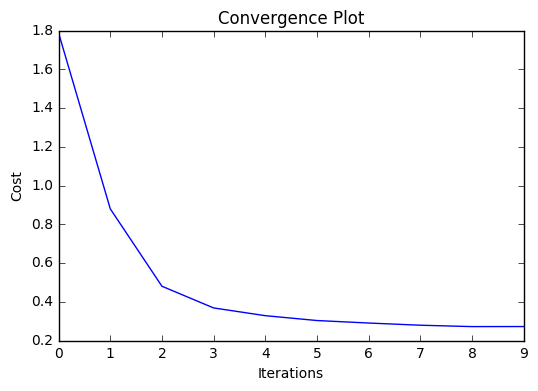

In [7]:
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

plt.plot(bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [8]:
similar_items = bpr.get_similar_items(N = 5)
similar_items

array([[  49,  116,  150,  180,  236],
       [ 401,  232,  127,  801,  548],
       [ 408,  621,  452,  128,  585],
       ..., 
       [1391, 1522, 1467, 1416, 1443],
       [1429, 1445, 1562, 1350, 1559],
       [1166, 1473, 1433, 1445, 1222]], dtype=int32)

In [9]:
recommendation = bpr.recommend(X_train, N = 5)
recommendation

array([[  6,  69, 274,  41, 355],
       [ 99, 326, 317,   8, 293],
       [301, 867, 300, 299, 244],
       ..., 
       [126,  49,  99,  24, 465],
       [287,  99, 293, 171, 285],
       [143,   0,  81, 203,   6]], dtype=int32)